In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# Create a function to return the Pearson Correlation coefficient given two variables
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [3]:
# Import the dataset
df = pd.read_csv('https://assets.datacamp.com/production/repositories/470/datasets/f1e7f8a98c18da5c60b625cb8af04c3217f4a5c3/female_literacy_fertility.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          162 non-null    object 
 1   Continent        162 non-null    object 
 2   female literacy  162 non-null    float64
 3   fertility        162 non-null    float64
 4   population       162 non-null    object 
dtypes: float64(2), object(3)
memory usage: 6.5+ KB


In [5]:
df.columns

Index(['Country ', 'Continent', 'female literacy', 'fertility', 'population'], dtype='object')

In [6]:
# Create illiteracy column
df['illiteracy'] = 100 - df['female literacy']

In [7]:
df.head()

,Country,Continent,female literacy,fertility,population,illiteracy
0,Chine,ASI,90.5,1.769,"1,324,655,000",9.5
1,Inde,ASI,50.8,2.682,"1,139,964,932",49.2
2,USA,NAM,99.0,2.077,"304,060,000",1.0
3,Indonésie,ASI,88.8,2.132,"227,345,082",11.2
4,Brésil,LAT,90.2,1.827,"191,971,506",9.8


In [8]:
illiteracy = df.illiteracy

In [9]:
fertility = df.fertility

Text(0, 0.5, 'fertility')

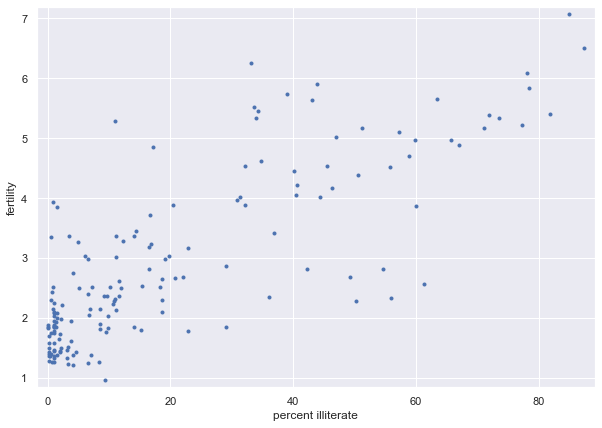

In [10]:
# Plot the illiteracy rate versus fertility
sns.set()
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(illiteracy, fertility, marker='.', linestyle='none')

# Set the margins and label axes
plt.margins(0.02)
plt.xlabel('percent illiterate')
plt.ylabel('fertility')

In [11]:
# Show the Pearson correlation coefficient
print(f"Pearson coeff: {pearson_r(illiteracy, fertility)}")

Pearson coeff: 0.8041324026815344


You can see the correlation between illiteracy and fertility by eye, and by the substantial Pearson correlation coefficient of 0.8. It is difficult to resolve in the scatter plot, but there are many points around near-zero illiteracy and about 1.8 children/woman

## Linear Regression using numpy

In [12]:
# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(illiteracy, fertility, 1)

# Print the results to the screen
print('slope =', a, 'children per woman / percent illiterate')
print('intercept =', b, 'children per woman')

slope = 0.04979854809063423 children per woman / percent illiterate
intercept = 1.888050610636557 children per woman


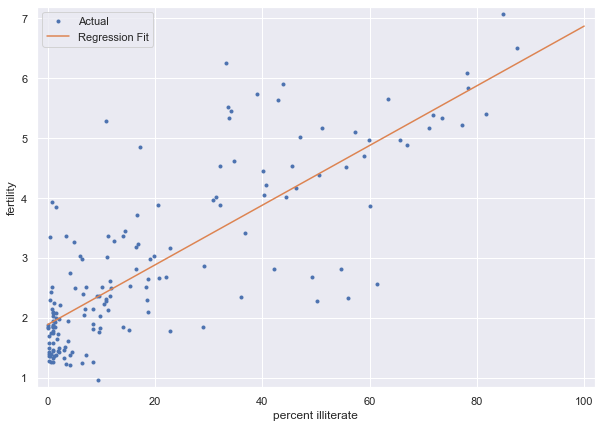

In [13]:
# Plot the illiteracy rate versus fertility
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(illiteracy, fertility, marker='.', linestyle='none', label='Actual')
plt.margins(0.02)
plt.xlabel('percent illiterate')
plt.ylabel('fertility')

# Make theoretical line to plot
x = np.array([0,100])
y = a * x + b

# Add regression line to your plot
plt.plot(x, y, label='Regression Fit')
plt.legend()

To independently confirm that the slope derived from the np.polyfit() is indeed the value of the slope that gives

## Create a function to do pairs bootstrap

In [14]:
## Create a function to do pairs bootstrap

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

In [15]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(illiteracy, fertility, size=1000)

In [16]:
# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5,97.5]))

[0.044066  0.0555368]


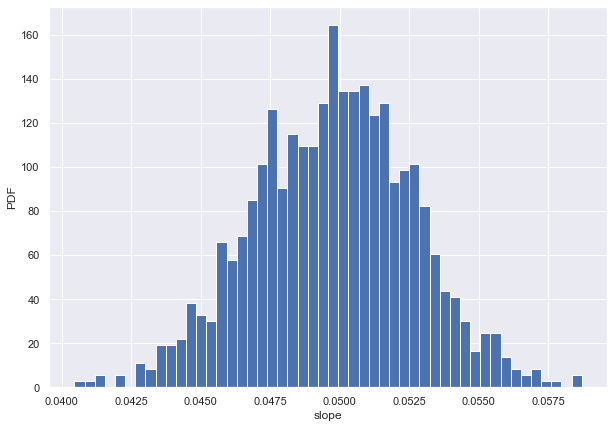

In [17]:
# Plot the histogram
fig, ax = plt.subplots(figsize=(10,7))
_ = plt.hist(bs_slope_reps, bins=50, density=True)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')

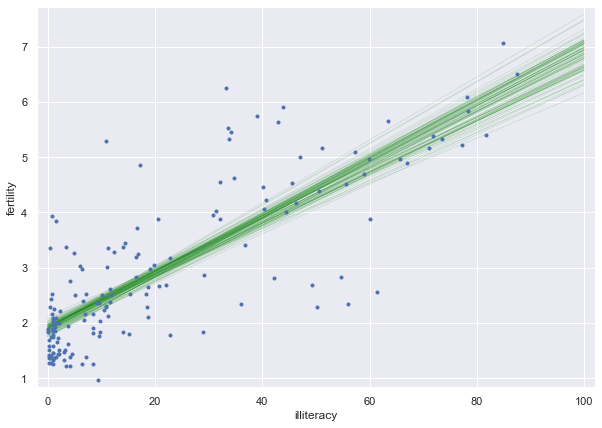

In [18]:
# Plot the slopes of the lines from the bootstrap replicate pairs
# Generate array of x-values for bootstrap lines: x
x = np.array([0,100])

# Plot the bootstrap lines
fig, ax = plt.subplots(figsize=(10,7))
for i in range(100):
    plt.plot(x, bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='green')
    
# Plot the data
plt.plot(illiteracy, fertility, marker='.', linestyle='none')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('illiteracy')
_ = plt.ylabel('fertility')
plt.margins(0.02)

In [19]:
len(bs_slope_reps)

1000

## Hypothesis test on Pearson correlation
The observed correlation between female illiteracy and fertility may just be by chance; the fertility of a given country may actually be totally independent of its illiteracy. 

We will test this hypothesis by permuting the illiteracy values but leave the fertility values fixed. This simulates the hypothesis that they are totally independent of each other and not correlated.

In [20]:
# Make a function to create a test statistic of the difference of the means of data
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [21]:
# Create permutation sample function
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data2):]

    return perm_sample_1, perm_sample_2

In [22]:
# Create a function to generate permutation replicates with a passed function as a test statistic
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [25]:
# Compute observed correlation: r_obs
r_obs = pearson_r(illiteracy, fertility)

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    illiteracy_permuted = np.random.permutation(illiteracy)

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(illiteracy_permuted, fertility)

# Compute p-value: p
p = np.sum(perm_replicates >= r_obs) / len(perm_replicates)
print('p-val =', p)

p-val = 0.0


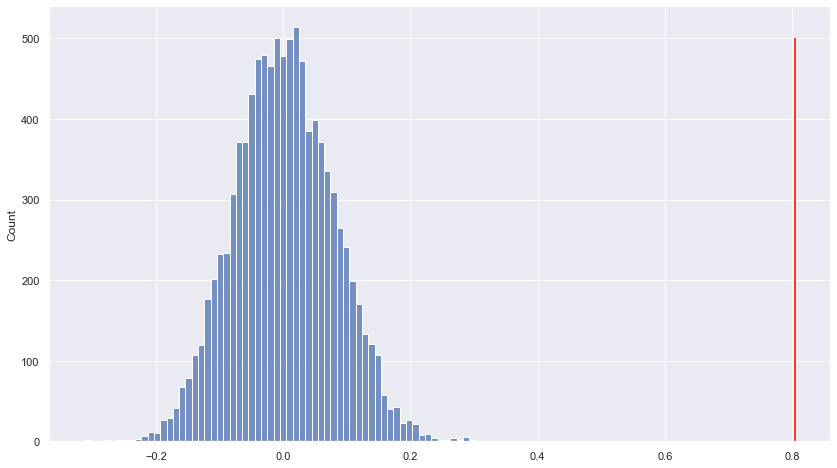

In [43]:
# Plot the distribution histogram with the observed value to confirm the p-value of zero 
plt.figure(figsize=(14, 8))
sns.histplot(perm_replicates)
plt.vlines(r_obs,ymin=0, ymax=500,color='red', linestyle='-', label='Observed p coeff')